## Charlie Jiang - cj2630

# Deep Learning In Biomedical Imaging
## BMENE4460-2023-1

### <span style="color:red">Midterm examination</span> - Vanilla U-Net for single cell segmentation

#### Due date/time: <span style="color:red">March 23, 9:00 am(EST)</span>

#### Instructions:
1. You may use any publicly available resources to answer the questions, but you need to ***cite*** them properly to prevent plagiarism.
2. Using or copying other students' solutions is considered cheating, and you'll be graded **"0" for the entire exam**.
3. We have marked the places that you need to fill according to what has been asked in the PDF.
4. Please define your variables with ***short and meaningful names***.
5. Please make sure ***internet access is granted*** on the settings panel.
6. For this exam, you ***need GPU access***. Please set the "Accelerator" as "GPU" on the "Setting" panel.

#### <span style="color:red">Midterm Questions:</span> Please find the questions in the cell blocks below and implement them by yourself. Please note that you can NOT use any predefined functions from any libraries for Q5 (calculating JI):
Overall points: 100
1. Converting color image to grayscale images (20 pts)
2. Implementing histogram equalization as a preprocessing procedure (20 pts)
3. Modifying the UNet architecture by adding another encoding and decoding layers (20 pts)
4. Printing the number of total parameters of your model (20 pts)
5. Implementing Jaccard index as an evaluation metrics (20 pts)
6. (Bonus question, 10 points, it worth 2.5 points in your final grade) Improving the model performance you implemented above. You may find more details at the end of this notebook.

#### How to submit:
Since the dataset is available on Kaggle, we encourage you to upload the notebook and work on Kaggle. You can also download the dataset and finish it on your local computer.

If working on any cloud-based notebook server, after finishing, download the notebook and upload it to the Courseworks.

#### This is basically the notebook we had provided for lecture 8. However, there are some modification/optimization that you need to consider to implement your part properly. Please read the notebook carefully!

#### Sections:
1. Add the "Single Cell Segmentation Dataset" and create Data Loader
2. Implement U-Net model (Modified version)
3. Train the model
4. Display results

### Import the necessary packages.

In [1]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

#### Check GPU availability (should be False if you run without GPU Accelerator, to turn it on, go to Settings->Accelerator on the right panel and select GPU).

In [2]:
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

GPU available: True


Also make sure the internet access is on.

#### Set the random seed for reproducibility.

The random seed helps to make sure that the model parameter initialization, sequence of random shuffling, and most other nondeterministic operations are kept the same each time you run this notebook.

In [3]:
torch.manual_seed(4460)
np.random.seed(4460)

### 1. Add the "Single Cell Segmentation Dataset" and create Data Loader
Note: If the dataset is already added, you can skip this section.

#### 1.1 First, we need to add the dataset to the our notebook. Follow these steps:

##### 1.1.1. Click on "Add Data" button on "Data" panel.

<div align="center">
  <img src="https://github.com/soroush361/AoE_BME/blob/main/data_panel.png?raw=true" />
</div>

##### 1.1.2. Search for "SingleCellSegmentation" dataset and click on "Add" button.

<div align="center">
  <img width="600px" src="https://github.com/soroush361/AoE_BME/blob/main/singlecellseg_dataset.png?raw=true" />
</div>

##### 1.1.3. Wait till the download is finished.

<div align="center">
  <img width="1200px" src="https://github.com/soroush361/AoE_BME/blob/main/downloading_dataset.png?raw=true" />
</div>

##### 1.1.4. You should see these folders in input folder of your notebook.

<div align="center">
  <img src="https://github.com/soroush361/AoE_BME/blob/main/singlecellseg_dataset_added.png?raw=true" />
</div>

#### 1.2 Let us check how many samples we have in each folder (train, valid, test).

In **"train"** folder we must have 4140 samples, in **"valid"** folder 1380 samples, and in **"test"** folder there must be 2070 samples.

In each of these three folders, you’ll see two subfolders: **"image"**, and **"mask"**.  In the **"image"** folder, you’ll find several colored PNG images with a format of `image_{i:04}.png` where `i` starts from 1 to the number of samples in each set (E.g., for the train 1 to 4140, and for the test, 1 to 2070). These colored images must be used as the inputs for each phase. Similarly, you’ll find their corresponding binary masks in ** “mask”** folder with a format of `mask_{i:04}.png`.

We may count the number of files in each folder using the `!ls` bash command and pipe it with the `wc -l` command. For example:

In [4]:
!ls /kaggle/input/singlecellsegmentation/SingleCellSegmentation/train/image/image_*.png | wc -l

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
!dir data\SingleCellSegmentation\train\image | find /c ".png" 

4140


In [6]:
!ls /kaggle/input/singlecellsegmentation/SingleCellSegmentation/valid/image/image_*.png | wc -l

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
!dir data\SingleCellSegmentation\valid\image | find /c ".png" 

1380


In [8]:
!ls /kaggle/input/singlecellsegmentation/SingleCellSegmentation/test/image/image_*.png | wc -l

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
!dir data\SingleCellSegmentation\test\image | find /c ".png" 

2070


#### 1.3 Create the DataLoaders for each set (train, valid, and test)

Unlike the MNIST example, we cannot load all the images and their masks at once and train our network. We need to read each batch of the images/masks and then train the network with that batch. This process should be repeated for other batches. This way, we will only have one batch at a time on the memory, preventing memory overflow.

To do so, we need a `BasicDataset` instance that reads an image and respective segmentation mask. \
In below, we implemented the `BasicDataset` class that does the job. Furthermore, you can implement any kinds of preprocessing you wish to do in this implementation. For example, in this class, we resized the resolutions to $256\times256$ pixels to speed up the training process (Original resolution is $512\times512$) and reduce memory consumption. In addition, we scaled the intensities from $[0, 255]$ to $[0, 1]$. \
Since we will use **Pytorch** and Pytroch's input shape format is $[Batch, Channels, Height, Width]$ rather than $[Batch, Height, Width, Channels]$, we need to changed the image axis as well.

### <span style="color:red">Q1&2: Please answer Q1 and Q2 below:</span>

In [10]:
data_root_folder = './data/SingleCellSegmentation/'
class BasicDataset(TensorDataset):
    # This function takes folder name ('train', 'valid', 'test') as input and creates an instance of BasicDataset according to that folder.
    # Also if you'd like to have less number of samples (for evaluation purposes), you may set the `n_sample` with an integer.
    def __init__(self, folder, n_sample=None):
        self.folder = os.path.join(data_root_folder, folder)
        self.imgs_dir = os.path.join(self.folder, 'image')
        self.masks_dir = os.path.join(self.folder, 'mask')
        
        self.imgs_file = sorted(glob.glob(os.path.join(self.imgs_dir, '*.png')))
        self.masks_file = sorted(glob.glob(os.path.join(self.masks_dir, '*.png')))
        
        assert len(self.imgs_file) == len(self.masks_file), 'There are some missing images or masks in {0}'.format(folder)
        
        # If n_sample is not None (It has been set by the user)
        if not n_sample or n_sample > len(self.imgs_file):
            n_sample = len(self.imgs_file)
        
        self.n_sample = n_sample
        self.ids = list([i+1 for i in range(n_sample)])
            
    # This function returns the lenght of the dataset (AKA number of samples in that set)
    def __len__(self):
        return self.n_sample
    
    
    # This function takes an index (i) which is between 0 to `len(BasicDataset)` (The return of the previous function), then returns RGB image, 
    # mask (Binary), and the index of the file name (Which we will use for visualization). The preprocessing step is also implemented in this function.
    def __getitem__(self, i):
        idx = self.ids[i]
        img = cv2.imread(os.path.join(self.imgs_dir, 'image_{0:04d}.png'.format(idx)), cv2.IMREAD_COLOR)
        mask = cv2.imread(os.path.join(self.masks_dir, 'mask_{0:04d}.png'.format(idx)), cv2.IMREAD_GRAYSCALE)

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        '''[(Q1) Converting RGB image to grayscale image: your answer here]'''
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        '''[(Q2) Applying histogram equalization to the grayscale image: your answer here]'''        
        img = cv2.equalizeHist(img)
        
        #Resize all images from 512 to 256 (H and W)
        img = cv2.resize(img, (256,256))
        mask = cv2.resize(mask, (256,256))
        
        # Scale between 0 to 1
        img = np.array(img) / 255.0
        mask = np.array(mask) / 255.0
        
        # Make sure that the mask are binary (0 or 1)
        mask[mask <= 0.5] = 0
        mask[mask > 0.5] = 1
        
        # Add an axis to the image array so that it is in [channel, height, width] format.
        img = np.expand_dims(img, axis=0)
        
#         # HWC to CHW
#         img = np.transpose(img, (2, 0, 1))
        

        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.LongTensor),
            'img_id': idx
        }

Now we can create our three datasets and display the number of samples in each set in a pythonic way.

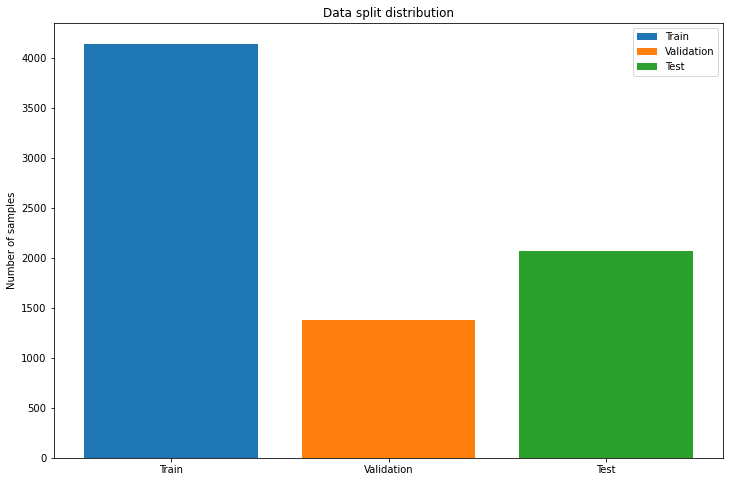

In [11]:
# Create train, validation, and test dataset instances
train_dataset = BasicDataset('train')
valid_dataset = BasicDataset('valid')
test_dataset = BasicDataset('test')


plt.figure(figsize=(12,8))
plt.title('Data split distribution')
plt.bar(0, len(train_dataset), label='Train')
plt.bar(1, len(valid_dataset), label='Validation')
plt.bar(2, len(test_dataset), label='Test')
plt.ylabel('Number of samples')
plt.xticks([0,1,2],['Train', 'Validation', 'Test'])
plt.legend()
plt.show()

Also, let's check if our `BasicDataset` implementation works by pulling out a random sample of the training set.

(Don't forget that we need to reverse some of the preprocessing steps, like changing the axis format and rescaling the image intensity to `[0, 255]`)

x shape is torch.Size([1, 256, 256])
y shape is torch.Size([256, 256])


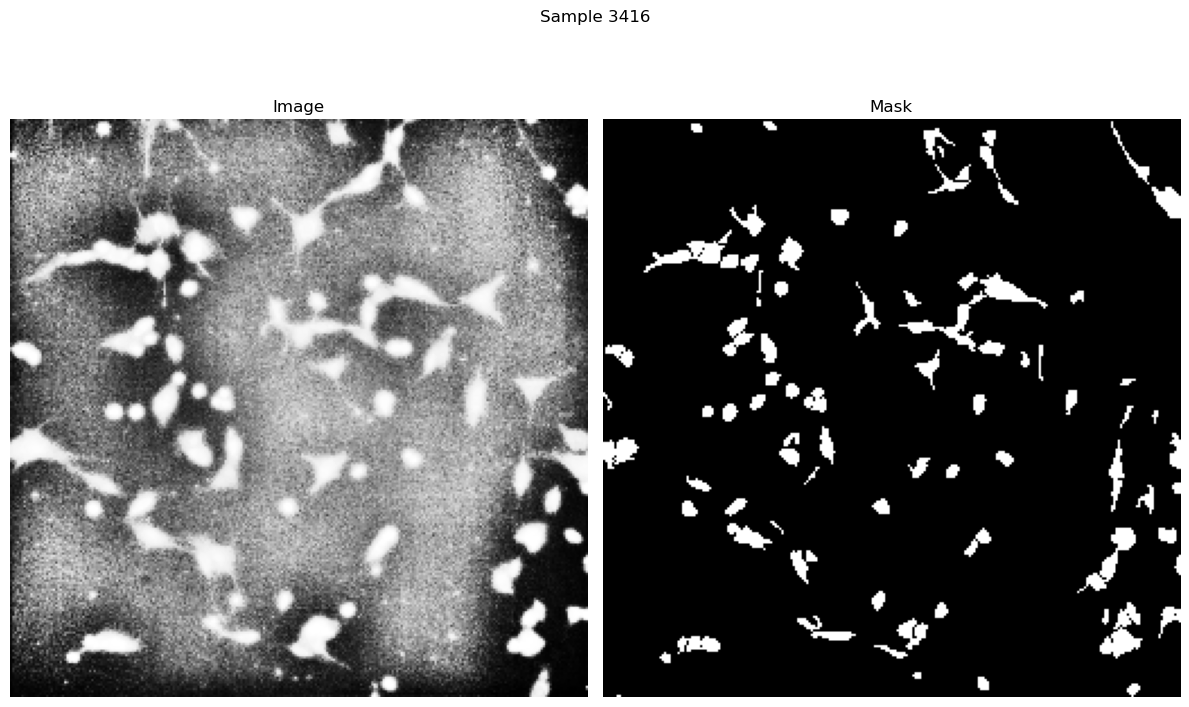

In [12]:
sample = np.random.randint(0, len(train_dataset))
data = train_dataset.__getitem__(sample)
x = data['image']
y = data['mask']
idx = data['img_id']

print(f'x shape is {x.shape}')
print(f'y shape is {y.shape}')

plt.figure(figsize=(12, 8), dpi=100)
plt.suptitle(f'Sample {idx:04d}')
img = x[0]
mask = y
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

Now that we have made sure our dataset implementation works fine, we can make the `DataLoader` per each set. We will set the batch size as **4** for all sets.

<span style="color:red;font-size:18px;" font>Important Note</span>: For this tutorial, we choose to work with **1000** samples for training, **200** samples for validation, and **200** samples for testing to reduce the training time. In your final project, you should use the whole dataset.

In [13]:
# Re-create train, validation, and test dataset instances to reduce the number of samples and expedite the training process.
train_dataset = BasicDataset('train', n_sample=1000)
valid_dataset = BasicDataset('valid', n_sample=200)
test_dataset = BasicDataset('test', n_sample=200)

# Modified Num_Workers cuz training on own GPU machine
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, num_workers=0, pin_memory=True)

### 2. Implement U-Net model (Modified version)

Now that we have set up our data loaders, we can implement the architecture.

**We provided the code (Class UNet) for the following architecture**:

<div align="center">
  <img width="800px" src="https://github.com/soroush361/AoE_BME/blob/main/modified_UNet_arch_2.png?raw=true" />
</div>




**You are asked to MODIFY the provided code to implement the following architecture: **

<div align="center">
  <img width="800px" src="https://raw.githubusercontent.com/XuzheZ/bmen4460/main/Picture1.png" />
</div>


To implement this modified U-Net, we first define four blocks that we will use multiple times while designing the complete architecture. \
`DoubleCov` is block that contains these layers: Conv2d->BatchNormalization->ReLU->Conv2d->BatchNormalization->ReLU \
`Down` is a downsampling block that contains Maxpooling and `DoubleConv` after Maxpooling. (Decoding layers) \
`Up` is an upsampling block that upsamples the input then pass it through a `DoubleConv.` (Encoding Layers) \
`OutConv` is just a $(1\times1)$ 2D convolution followed by a Sigmoid activation that serves as an output layer in our U-Net model.


In [14]:
######################################## Double Convolution
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

    
######################################## Maxpooling followed by Double Convolution
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


######################################## Upsampling followed by Double Convolution
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
        ) 
        self.conv = DoubleConv(out_channels * 2, out_channels)


    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x

######################################## Output layer (1x1 Convolution followed by SoftMax activation)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv_sigmoid = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv_sigmoid(x)

Now we can mix the above modules to build our architecture.

We will assign `name`, `n_channels`, and `n_classes` to our implementation for organization purposes. In this case, we may set `name` as an arbitrary name (e.g., 'MyUNet'), `n_channels` must be **1** (Since the input image is gray), and `n_classes` must be **2** (One channel to show the likelihood for background and one for the cells).

### <span style="color:red">Q3. Modify the UNet code based on the figure above.</span>
**Please NOTICE that the code provided below is not what we ask for. We ask you to modify the code below to match the *second network architecture***

In [15]:
class UNet(nn.Module):
    
    
    
    def __init__(self, name, n_channels, n_classes):
        super(UNet, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes
        '''[(Q3) Adding additional encoding and decoding layers below]'''
        self.inputL = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        
        #additional
        self.downX = Down(512,512)
        
        self.down4 = Down(512, 1024)
        
        self.up1 = Up(1024, 512)
        
        #additional
        self.upX = Up(512,512)
        
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outputL = OutConv(64, n_classes)
        
        '''[(Q3) Modify the forward module below]'''
    def forward(self, x):
        x1 = self.inputL(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        #additional
        xX = self.downX(x4)
        
        b = self.down4(xX)
        
        x = self.up1(b, xX)
        
        #additional 
        x = self.upX(x,x4)
        
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        x = self.outputL(x)
        
        return x

Now we can create an instance of our implemented model.

In [16]:
# define the channel number first
inp_channel = 1
opt_channel = 2
my_UNet = UNet('MyUNet', inp_channel, opt_channel)
my_UNet.cuda()

UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mom

### <span style="color:red">Q4. Printing the number of total model parameters here</span>

In [17]:
#'''[(Q4) Printing the parameter number]'''

#Source: https://wandb.ai/wandb_fc/tips/reports/How-to-Calculate-Number-of-Model-Parameters-for-PyTorch-and-Tensorflow-Models--VmlldzoyMDYyNzIx
total_params = sum(param.numel() for param in my_UNet.parameters())

print("Total Parameter Count is: {}".format(total_params))

Total Parameter Count is: 41018754


Although we have not trained our model, we may see the output with random weights. Thus, we will pull a batch of test data loader, get the network's output, and plot it.

Sample batch 'image 'shape is: torch.Size([4, 1, 256, 256])
Sample batch 'mask' shape is: torch.Size([4, 256, 256])
Predicted mask shape is: torch.Size([4, 2, 256, 256])
(256, 256)
[[ 5  8 11 ...  2  7  3]
 [ 8  4  6 ...  4  4  4]
 [10 14  7 ...  2 13  5]
 ...
 [ 4  2  2 ...  0  0  0]
 [ 1  3  1 ...  0  0  0]
 [ 3  4  3 ...  1  1  1]]


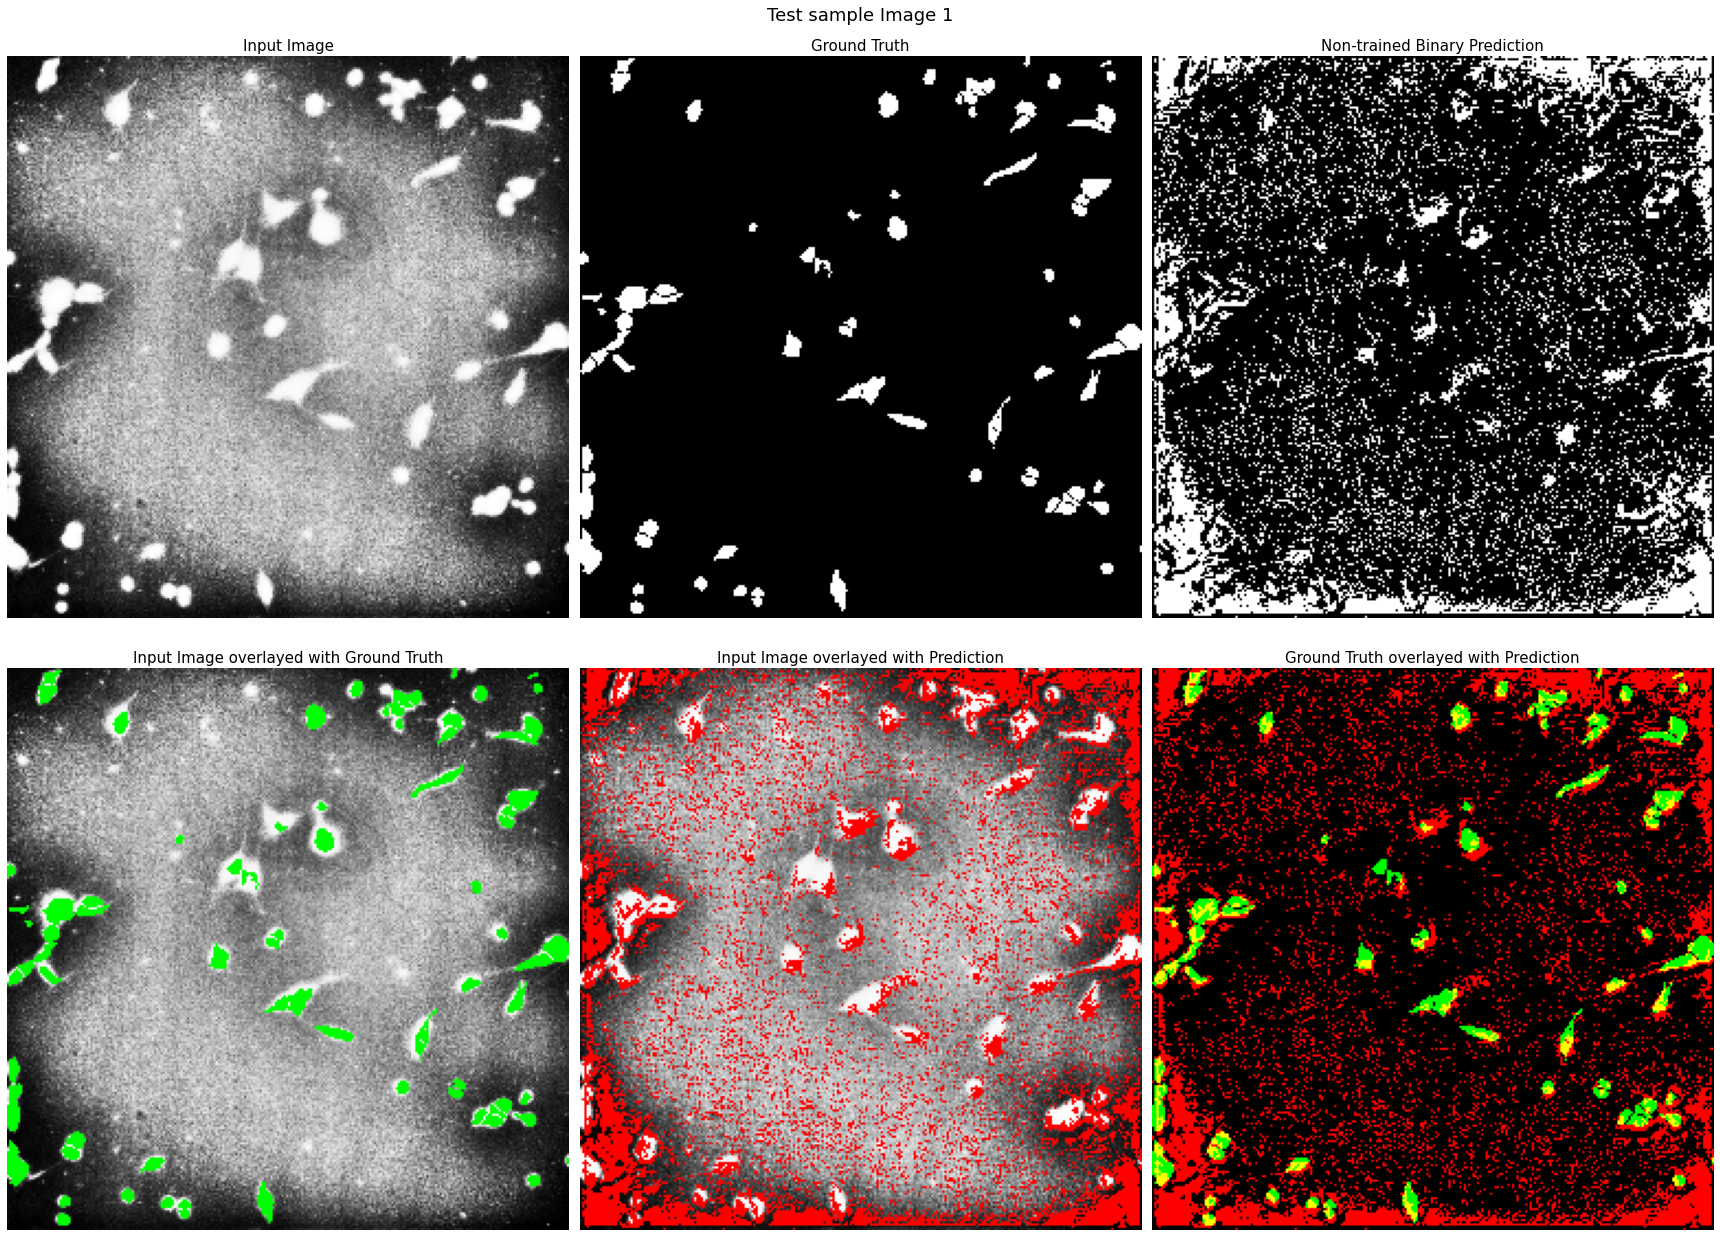

In [18]:
# Take the first batch
for batch in test_dataloader:
    sample_batch = batch
    break
    
# Generat network prediction
with torch.no_grad():
    y_pred = my_UNet(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(sample_batch['image'].shape, 
                                                                                                                       sample_batch['mask'].shape,
                                                                                                                       y_pred.shape
                                                                                                                      ))

# Conver Pytorch tensor to numpy array then reverse the preprocessing steps
img = (sample_batch['image'][0][0].numpy() * 255).astype('uint8')
msk = (sample_batch['mask'][0].numpy() * 255).astype('uint8')

print(img.shape)
print(img)
# Using `np.argmax()`, we may choose the maximum likelihood to assign a label for each pixel
pred_msk_binary = (np.argmax(y_pred.cpu().numpy()[0], axis=0) * 255).astype('uint8')
# pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,18))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(2,3,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')


plt.subplot(2,3,3)
plt.title('Non-trained Binary Prediction', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

input_overlayed_GT = img.copy()
input_overlayed_GT = cv2.cvtColor(input_overlayed_GT, cv2.COLOR_GRAY2RGB)
input_overlayed_GT[msk == 255, :] = [0, 255, 0]
plt.subplot(2,3,4)
plt.title('Input Image overlayed with Ground Truth', fontsize=15)
plt.imshow(input_overlayed_GT)
plt.axis('off')

input_overlayed_Pred = img.copy()
input_overlayed_Pred = cv2.cvtColor(input_overlayed_Pred, cv2.COLOR_GRAY2RGB)
input_overlayed_Pred[pred_msk_binary == 255, :] = [255, 0, 0]
plt.subplot(2,3,5)
plt.title('Input Image overlayed with Prediction', fontsize=15)
plt.imshow(input_overlayed_Pred)
plt.axis('off')

GT_overlayed_prediction = np.zeros_like(img)
GT_overlayed_prediction = cv2.cvtColor(GT_overlayed_prediction, cv2.COLOR_GRAY2RGB)
GT_overlayed_prediction[msk == 255, 1] = 255
GT_overlayed_prediction[pred_msk_binary == 255, 0] = 255
plt.subplot(2,3,6)
plt.title('Ground Truth overlayed with Prediction', fontsize=15)
plt.imshow(GT_overlayed_prediction)
plt.axis('off')

plt.tight_layout()
plt.show()

As you can see, the predicted mask is not nearly close to the ground truth because we didn't train the network!

### 3. Train the model

#### 3.1 Optimizer and Loss function

Before working on the training loop, let's define the **optimizer** and the **loss function**.
In this example, we will use the **"ADAM"** algorithm for the optimizer, and for the loss function, we will use **"Cross-Entropy"**. You may change these later to see how different optimization algorithms and loss functions may affect the performance.

For the optimizer, we need to provide the network parameters and define the learning rate. Let's set it as `0.001` for now.

In [19]:
optimizer = torch.optim.Adam(my_UNet.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

#### 3.2 Training loop

In MNIST example, you saw the training loop is very complecated and there are alot of things happening at the same time. Thus, we provide you with a single function, name `traine_net`, that takes the following arguments and trains the network. The input arguments are:

1. `net`: The model you want to train.
2. `epochs`: Number of epochs you want to train the network.
3. `train_dataloader`: The training set `DataLoader`.
4. `valid_dataloader`: The validation set `DataLoader`.
5. `optimizer`: The optimizer algorithm.
6. `loss_function`: The loss function.

This function creates a directory in `/kaggle/working/{model_name}`, and saves the model weights per each epoch (starts at 1 for the first epoch). Also, it will calculate the [DICE score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) for both training and validation samples.

<span style="color:red">In Question 5, we asked you to add Jaccard function as well and return that index too.</span>

Then, the return values of this function are:

1. `train_loss`: A list of average training loss per each epoch.
2. `train_dice`: A list of average training DICE score per each epoch.
3. `train_jaccard`: A list of average training Jaccard score per each epoch.
4. `valid_loss`: A list of average validation loss per each epoch.
5. `valid_dice`: A list of average validation DICE score per each epoch.
6. `valid_jaccard`: A list of average validation Jaccard score per each epoch.

### <span style="color:red">Q5. Implementing Jaccard Index below</span>

In [20]:
# Define a function that computes the Jaccard score for binary segmentation

def jaccard_coeff_binary(y_pred, y_true):
        '''[(Q5) Your answer here - hint: check the equation of Jaccard Index here:https://en.wikipedia.org/wiki/Jaccard_index, do not use predefined jaccard index functions provided in any libraries ]'''
        '''
        y_p_all = y_pred.flatten()
        y_t_all = y_true.flatten()
        
        intersection = 0
        union = 0
        for i in range(len(y_p_all)):
            if y_p_all[i] == y_t_all[i] == 1:
                intersection += 1
            elif y_p_all[i] == y_t_all[i] ==0 :
                continue
            union+=1
        
        jaccard_index = intersection/union
        '''
        inter = torch.dot(y_pred.view(-1).float(), y_true.view(-1).float())
        union = torch.sum(y_pred.float()) + torch.sum(y_true.float()) - inter
        

        jaccard_index = inter/union

        return jaccard_index.cpu().numpy()

# Define a function that computes the DICE score for binary segmentation
def dice_coeff_binary(y_pred, y_true):
        """Values must be only zero or one."""
        eps = 0.0001
        inter = torch.dot(y_pred.view(-1).float(), y_true.view(-1).float())
        union = torch.sum(y_pred.float()) + torch.sum(y_true.float())
        return ((2 * inter.float() + eps) / (union.float() + eps)).cpu().numpy()
    

# The training function
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    if not os.path.isdir('{0}'.format(net.name)):
        os.mkdir('{0}'.format(net.name))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()
    train_jaccard = list()
    valid_jaccard = list()
    
    for epoch in range(epochs):
        
        ################################################################################################################################
        ########################################################### Training ###########################################################
        ################################################################################################################################
        net.train()
        train_batch_loss = list()
        train_batch_dice = list()
        train_batch_jaccard = list()
        
        for i, batch in enumerate(train_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)

            # Make the binary mask to compute the DICE score. Since the y_pred is a Pytoch tensor, we use `torch.argmax()` instead of `np.argmax()`.
            # the axis must be 1 instead of 0 because the format is [batch, channel, height, width]
            pred_binary = torch.argmax(y_pred, axis=1)
            
            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            train_batch_dice.append(batch_dice_score)
            
            # Compute the Jaccard score here and 
            batch_jaccard_score = jaccard_coeff_binary(pred_binary, true_masks)
            train_batch_jaccard.append(batch_jaccard_score)
            

            # Reset gradient values
            optimizer.zero_grad()

            # Compute the backward losses
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}            ', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.array(train_batch_dice).mean()
        average_training_jaccard = np.array(train_batch_jaccard).mean()
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)
        train_jaccard.append(average_training_jaccard)
        
        ################################################################################################################################
        ########################################################## Validation ##########################################################
        ################################################################################################################################
        
        net.eval()
        valid_batch_loss = list()
        valid_batch_dice = list()
        valid_batch_jaccard = list()
        
        # This part is almost the same as training with the difference that we will set all layers to evaluation mode (effects some layers such as BN and Dropout) and also
        # we don't need to calculate the gradient since we are only evaluating current state of the model. This will speed up the process and cause it to consume less memory.
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                # Load a batch and pass it to the GPU
                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()

                # Produce the estimated mask using current weights
                y_pred = net(imgs)

                # Compute the loss for this batch and append it to the epoch loss
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                # Make the binary mask to compute the DICE score. Since the y_pred is a Pytoch tensor, we use `torch.argmax()` instead of `np.argmax()`.
                # the axis must be 1 instead of 0 because the format is [batch, channel, height, width]
                pred_binary = torch.argmax(y_pred, axis=1)

                # Compute the DICE score for this batch and append it to the epoch dice
                batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
                valid_batch_dice.append(batch_dice_score)
                
                # Compute the Jaccard score here and append the score to the list
                batch_jaccard_score = jaccard_coeff_binary(pred_binary, true_masks)
                valid_batch_jaccard.append(batch_jaccard_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}            ', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_batch_dice).mean()
        average_validation_jaccard = np.array(valid_batch_jaccard).mean()
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        valid_jaccard.append(average_validation_jaccard)
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training DICE score: {average_training_dice}, Training Jaccard score: {average_training_jaccard}, Validation Loss: {average_validation_loss}, Validation DICE score: {average_validation_dice}, Validation Jaccard score: {average_validation_jaccard}')

        ################################################################################################################################
        ###################################################### Saveing Checkpoints #####################################################
        ################################################################################################################################
        torch.save(net.state_dict(), f'{net.name}/epoch_{epoch+1:03}.pth')
    
    return train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard

Now that we have everything in place, we can call the `train_net` function on our model and let it be trained for **10** epochs.

In [21]:
EPOCHS = 10
train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard = train_net(my_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

EPOCH 1/10 - Training Loss: 0.39897538459300996, Training DICE score: 0.7240806221961975, Training Jaccard score: 0.5689213871955872, Validation Loss: 0.35454816699028013, Validation DICE score: 0.7606179118156433, Validation Jaccard score: 0.6138774752616882
EPOCH 2/10 - Training Loss: 0.3597772082090378, Training DICE score: 0.7426736354827881, Training Jaccard score: 0.5912168025970459, Validation Loss: 0.34736991465091704, Validation DICE score: 0.7636929154396057, Validation Jaccard score: 0.6178766489028931
EPOCH 3/10 - Training Loss: 0.3557695226669311, Training DICE score: 0.7560257911682129, Training Jaccard score: 0.6081267595291138, Validation Loss: 0.34543121576309205, Validation DICE score: 0.7774307131767273, Validation Jaccard score: 0.6359423995018005
EPOCH 4/10 - Training Loss: 0.3537298992872238, Training DICE score: 0.7661741375923157, Training Jaccard score: 0.62132728099823, Validation Loss: 0.34236339330673216, Validation DICE score: 0.7969335317611694, Validation

### 4. Display results

Now that we have trained our network, let us see how it will perform on the test set. 

First, let us plot the learning curve and the DICE scores per epoch.

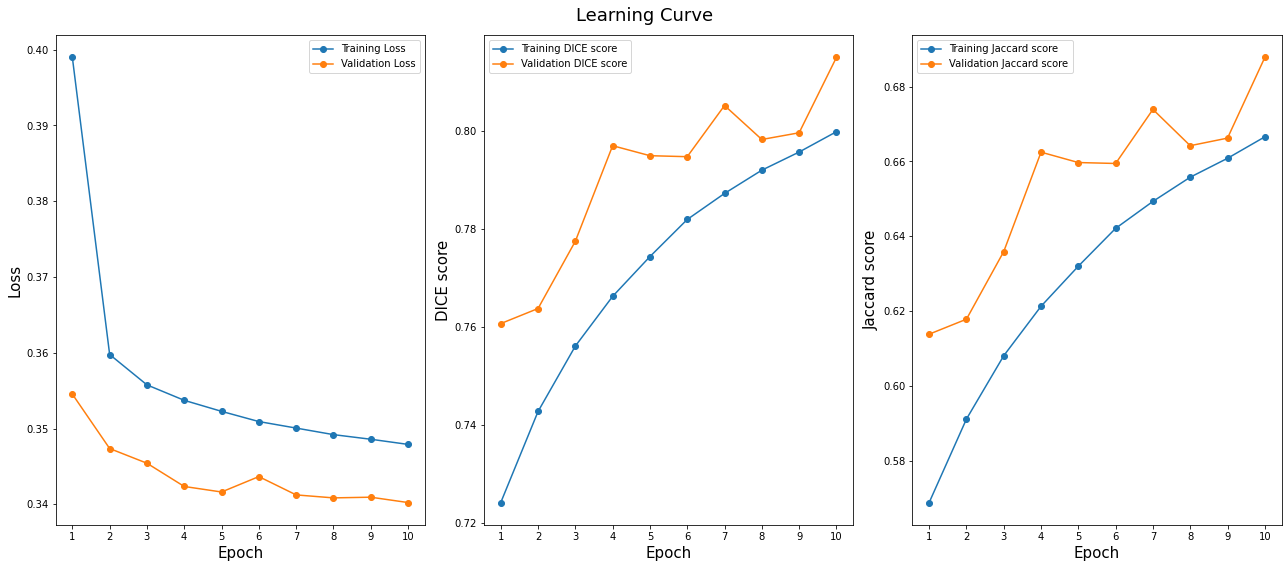

In [22]:
plt.figure(figsize=(18,8))
plt.suptitle('Learning Curve', fontsize=18)

plt.subplot(1,3,1)
plt.plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
plt.plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.arange(EPOCHS)+1, train_dice, '-o', label='Training DICE score')
plt.plot(np.arange(EPOCHS)+1, valid_dice, '-o', label='Validation DICE score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('DICE score', fontsize=15)
plt.legend()

plt.subplot(1,3,3)
plt.plot(np.arange(EPOCHS)+1, train_jaccard, '-o', label='Training Jaccard score')
plt.plot(np.arange(EPOCHS)+1, valid_jaccard, '-o', label='Validation Jaccard score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Jaccard score', fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()

Then, let us see in which epoch the model obtained the highest validation DICE score and load the weights of that epoch as our best model weights.

In [23]:
best_epoch = np.argmax(valid_dice) + 1 # The plus one is because the epochs starts at 1.

print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./MyUNet/epoch_{best_epoch:03}.pth')

my_UNet.load_state_dict(state_dict)
my_UNet.cuda()

Best epoch is epoch10


UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mom

Now we can check the performance of the best model on our previously pulled example. (The same scripts must work!)

Sample batch 'image 'shape is: torch.Size([4, 1, 256, 256])
Sample batch 'mask' shape is: torch.Size([4, 256, 256])
Predicted mask shape is: torch.Size([4, 2, 256, 256])


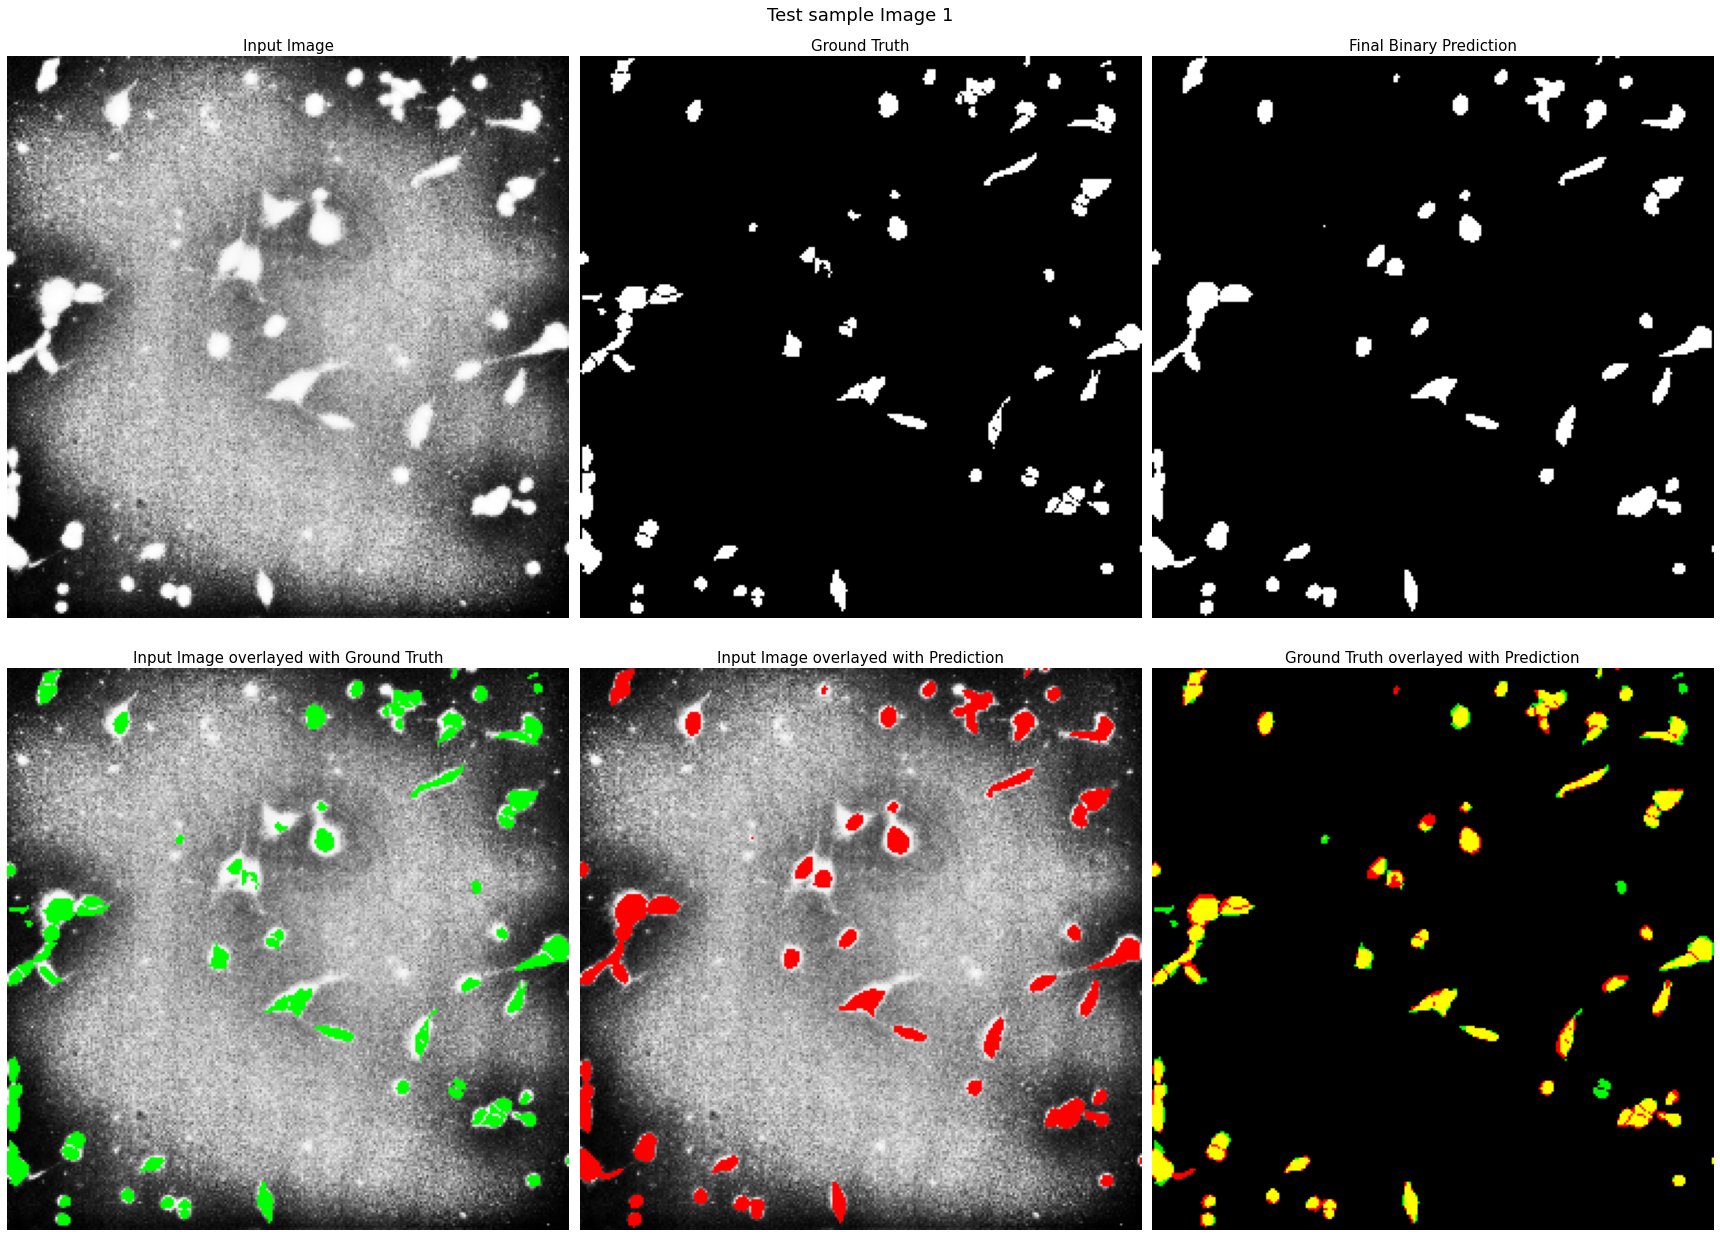

In [24]:
# Take the first batch of test set
for batch in test_dataloader:
    sample_batch = batch
    break
    
# Generat network prediction
with torch.no_grad():
    y_pred = my_UNet(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(sample_batch['image'].shape, 
                                                                                                                       sample_batch['mask'].shape,
                                                                                                                       y_pred.shape
                                                                                                                      ))

# Conver Pytorch tensor to numpy array then reverse the preprocessing steps
img = (sample_batch['image'][0][0].numpy() * 255).astype('uint8')
msk = (sample_batch['mask'][0].numpy() * 255).astype('uint8')

# Using `np.argmax()`, we may choose the maximum likelihood to assign a label for each pixel
pred_msk_binary = (np.argmax(y_pred.cpu().numpy()[0], axis=0) * 255).astype('uint8')
# pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,18))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(2,3,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')


plt.subplot(2,3,3)
plt.title('Final Binary Prediction', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

input_overlayed_GT = img.copy()
input_overlayed_GT = cv2.cvtColor(input_overlayed_GT, cv2.COLOR_GRAY2RGB)
input_overlayed_GT[msk == 255, :] = [0, 255, 0]
plt.subplot(2,3,4)
plt.title('Input Image overlayed with Ground Truth', fontsize=15)
plt.imshow(input_overlayed_GT)
plt.axis('off')

input_overlayed_Pred = img.copy()
input_overlayed_Pred = cv2.cvtColor(input_overlayed_Pred, cv2.COLOR_GRAY2RGB)
input_overlayed_Pred[pred_msk_binary == 255, :] = [255, 0, 0]
plt.subplot(2,3,5)
plt.title('Input Image overlayed with Prediction', fontsize=15)
plt.imshow(input_overlayed_Pred)
plt.axis('off')

GT_overlayed_prediction = np.zeros_like(img)
GT_overlayed_prediction = cv2.cvtColor(GT_overlayed_prediction, cv2.COLOR_GRAY2RGB)
GT_overlayed_prediction[msk == 255, 1] = 255
GT_overlayed_prediction[pred_msk_binary == 255, 0] = 255
plt.subplot(2,3,6)
plt.title('Ground Truth overlayed with Prediction', fontsize=15)
plt.imshow(GT_overlayed_prediction)
plt.axis('off')

plt.tight_layout()
plt.show()

As it is clear, the model is predicting the ground truth much better compared to before training.

However, we need to compute the overall performance of the model on all test samples. Then, similar to the `train_net` function, we can define a `test_net` function that tests our model on test samples and save the prediction masks in the `/kaggle/working/pred_mask` folder.

This function takes the following arguments:

1. `net`: The model we want to test.
2. `test_dataloader`: The `DataLoader` for the test set.
3. `loss_function`: The loss function to calculate the loss.

This function returns:
1. `test_loss`: The average test loss.
2. `test_dice`: The average test DICE score.
3. `test_jaccard`: The average test Jaccard score.
4. `test_accuracy`: The overall accuracy of the model.
5. `test_CM`: The normalized confusion matrix of the model.



In [25]:
def test_net(net, test_dataloader, loss_function):
    # Create the pred_mask folder
    if not os.path.isdir('./pred_mask'):
        os.mkdir('./pred_mask')
    
    net.eval()
    
    n_test = len(test_dataloader)
    test_batch_loss = list()
    test_batch_dice = list()
    test_batch_jaccard = list()
    test_batch_accuray = list()
    test_batch_CM = list()

    # This part is almost the same as the validation loop in `train_net` function. 
    # The difference is that we will calculate the accuracy and confusion matrix per each batch and save the predicted images.
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()
            img_ids = batch['img_id'].numpy().astype('int')

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            test_batch_loss.append(batch_loss)

            # Make the binary mask to compute the DICE score. Since the y_pred is a Pytoch tensor, we use `torch.argmax()` instead of `np.argmax()`.
            # the axis must be 1 instead of 0 because the format is [batch, channel, height, width]
            pred_binary = torch.argmax(y_pred, axis=1)

            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            test_batch_dice.append(batch_dice_score)
            
            # Compute the Jaccard score for this batch and append it to the epoch dice
            batch_jaccard_score = jaccard_coeff_binary(pred_binary, true_masks)
            test_batch_jaccard.append(batch_jaccard_score)
            
            # Save the predicted masks
            for idx, pred_msk in enumerate(pred_binary):
                cv2.imwrite(f'./pred_mask/pred_mask_{img_ids[idx]:04}.png', pred_msk.cpu().numpy())
            
            # Vectorize the true mask and predicted mask for this batch
            vectorize_true_masks = true_masks.view(-1).cpu().numpy()
            vectorize_pred_masks = pred_binary.view(-1).cpu().numpy()
            
            # Compute the accuracy for this batch and append to the overall list
            batch_accuracy = accuracy_score(vectorize_true_masks, vectorize_pred_masks)
            test_batch_accuray.append(batch_accuracy)
            
            # Compute the normalized confusion matrix for this batch and append to the overall list
            batch_CM = confusion_matrix(vectorize_true_masks, vectorize_pred_masks, normalize='true', labels=[0, 1])
            test_batch_CM.append(batch_CM)

            # Print the progress
            print(f'Test Batch {i+1}/{n_test} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}, Accuracy: {batch_accuracy}', end='\r')

    test_loss = np.array(test_batch_loss).mean()
    test_dice = np.array(test_batch_dice).mean()
    test_jaccard = np.array(test_batch_jaccard).mean()
    test_accuracy = np.array(test_batch_accuray).mean()
    test_CM = np.array(test_batch_CM).mean(axis=0)
    
    return test_loss, test_dice, test_jaccard, test_accuracy, test_CM

Let us use the function and see how it works!

Note: The accuracy and confusion matrix are computed on the CPU; thus, this function might be slower.

In [26]:
test_loss, test_dice, test_jaccard, test_accuracy, test_CM = test_net(my_UNet, test_dataloader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Jaccard score: {test_jaccard}, Test overall accuracy: {test_accuracy}')

Test Loss: 0.33652115523815157, Test DICE score: 0.8032984733581543, Test Jaccard score: 0.6713752746582031, Test overall accuracy: 0.9754557800292969


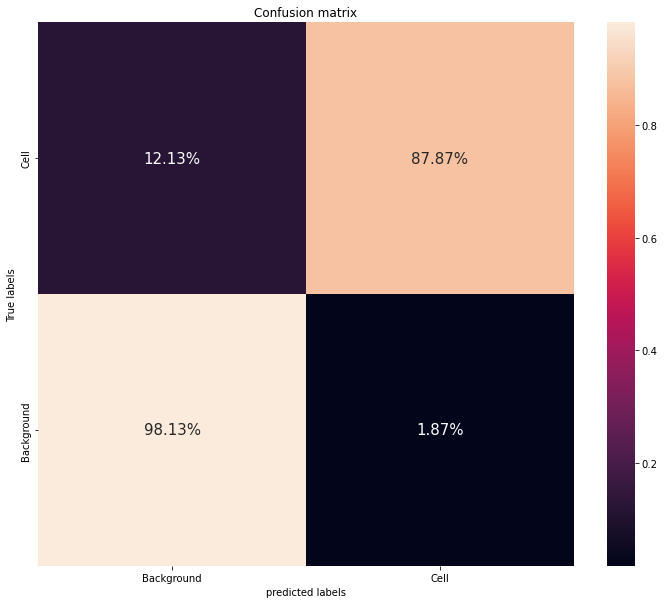

In [27]:
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2]);
plt.ylabel('True labels');
plt.xlabel('predicted labels');

### <span style="color:red">Q6. Bonus Question (10 pts).</span>

To improve the performance of the model you implemented above, you may consider implementing one of them or combining several of them, re-use the above code to print out your new results.
You should have a <span style="color:red">better</span> result comparing to the previous one:
1. Data preprocessing
2. Data augmentation
3. Network architecture (CNN layer, kernel ...)
4. Loss function 
5. Optimizer 
...

In [28]:
class OutConv2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
        )

    def forward(self, x):
        return self.conv(x)

In [29]:
class UNet_2(nn.Module):
    
    
    
    def __init__(self, name, n_channels, n_classes):
        super(UNet_2, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes
        '''[(Q3) Adding additional encoding and decoding layers below]'''
        self.inputL = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        
        #additional
        self.downX = Down(512,512)
        
        self.down4 = Down(512, 1024)
        
        self.up1 = Up(1024, 512)
        
        #additional
        self.upX = Up(512,512)
        
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outputL = OutConv2(64, n_classes)
        
        self.drop = torch.nn.Dropout(0.2)
        
        '''[(Q3) Modify the forward module below]'''
    def forward(self, x):
        x1 = self.inputL(x)
        
        x2 = self.down1(x1)
        x2 = self.drop(x2)
        
        x3 = self.down2(x2)
        x3 = self.drop(x3)
        x4 = self.down3(x3)
        x4 = self.drop(x4)
        #additional
        xX = self.downX(x4)       
        
        b = self.down4(xX)
        
        x = self.up1(b, xX)
        
        #additional 
        x = self.upX(x,x4)
        x = self.drop(x)
        x = self.up2(x, x3)
        x = self.drop(x)
        x = self.up3(x, x2)
        x = self.drop(x)
        x = self.up4(x, x1)
        
        x = self.outputL(x)
        
        return x

In [30]:
my_UNet2 = UNet_2('MyUNet2', inp_channel, opt_channel)
my_UNet2.cuda()
optimizer = torch.optim.Adam(my_UNet2.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [31]:
EPOCHS = 15
train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard = train_net(my_UNet2, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

EPOCH 1/15 - Training Loss: 0.14899305191636086, Training DICE score: 0.7176938652992249, Training Jaccard score: 0.5616113543510437, Validation Loss: 0.08822225928306579, Validation DICE score: 0.7657279372215271, Validation Jaccard score: 0.6205447316169739
EPOCH 2/15 - Training Loss: 0.11479989939928055, Training DICE score: 0.7366911768913269, Training Jaccard score: 0.583659827709198, Validation Loss: 0.08432643190026283, Validation DICE score: 0.7494004964828491, Validation Jaccard score: 0.6000927090644836
EPOCH 3/15 - Training Loss: 0.10912809148430824, Training DICE score: 0.7501767873764038, Training Jaccard score: 0.6006937623023987, Validation Loss: 0.0786336538940668, Validation DICE score: 0.777858555316925, Validation Jaccard score: 0.636593759059906
EPOCH 4/15 - Training Loss: 0.10421939849853516, Training DICE score: 0.7610765695571899, Training Jaccard score: 0.6146783232688904, Validation Loss: 0.07928059890866279, Validation DICE score: 0.7617849707603455, Validatio

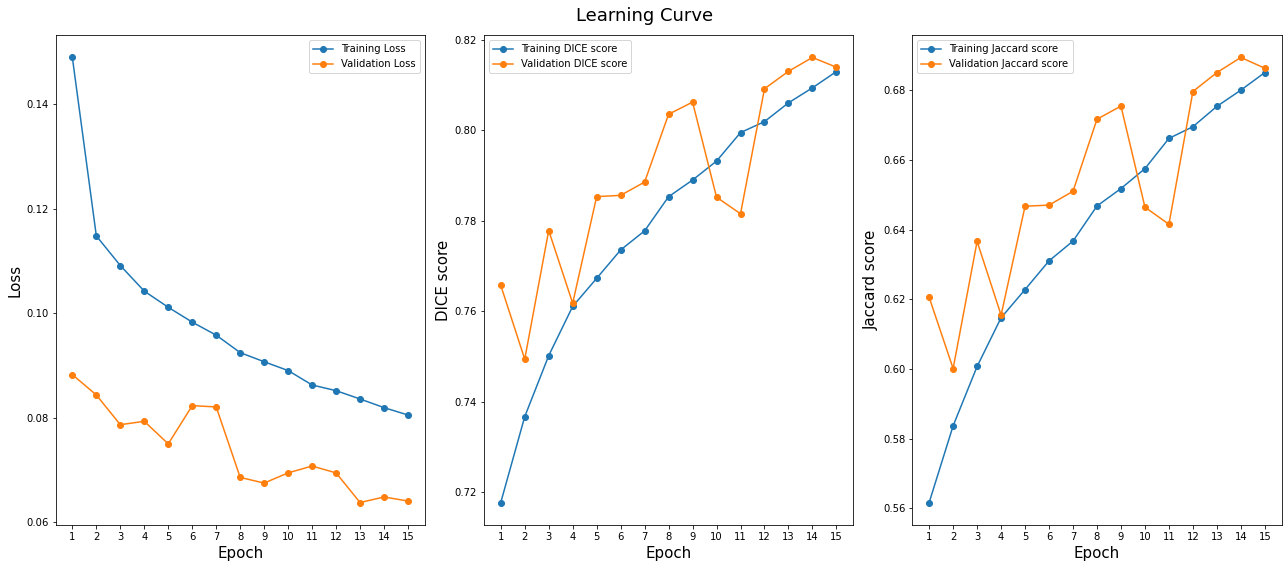

In [32]:
plt.figure(figsize=(18,8))
plt.suptitle('Learning Curve', fontsize=18)

plt.subplot(1,3,1)
plt.plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
plt.plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.arange(EPOCHS)+1, train_dice, '-o', label='Training DICE score')
plt.plot(np.arange(EPOCHS)+1, valid_dice, '-o', label='Validation DICE score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('DICE score', fontsize=15)
plt.legend()

plt.subplot(1,3,3)
plt.plot(np.arange(EPOCHS)+1, train_jaccard, '-o', label='Training Jaccard score')
plt.plot(np.arange(EPOCHS)+1, valid_jaccard, '-o', label='Validation Jaccard score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Jaccard score', fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
best_epoch = np.argmax(valid_dice) + 1 # The plus one is because the epochs starts at 1.

print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./MyUNet2/epoch_{best_epoch:03}.pth')

my_UNet2.load_state_dict(state_dict)
my_UNet2.cuda()

Best epoch is epoch14


UNet_2(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, m

Sample batch 'image 'shape is: torch.Size([4, 1, 256, 256])
Sample batch 'mask' shape is: torch.Size([4, 256, 256])
Predicted mask shape is: torch.Size([4, 2, 256, 256])


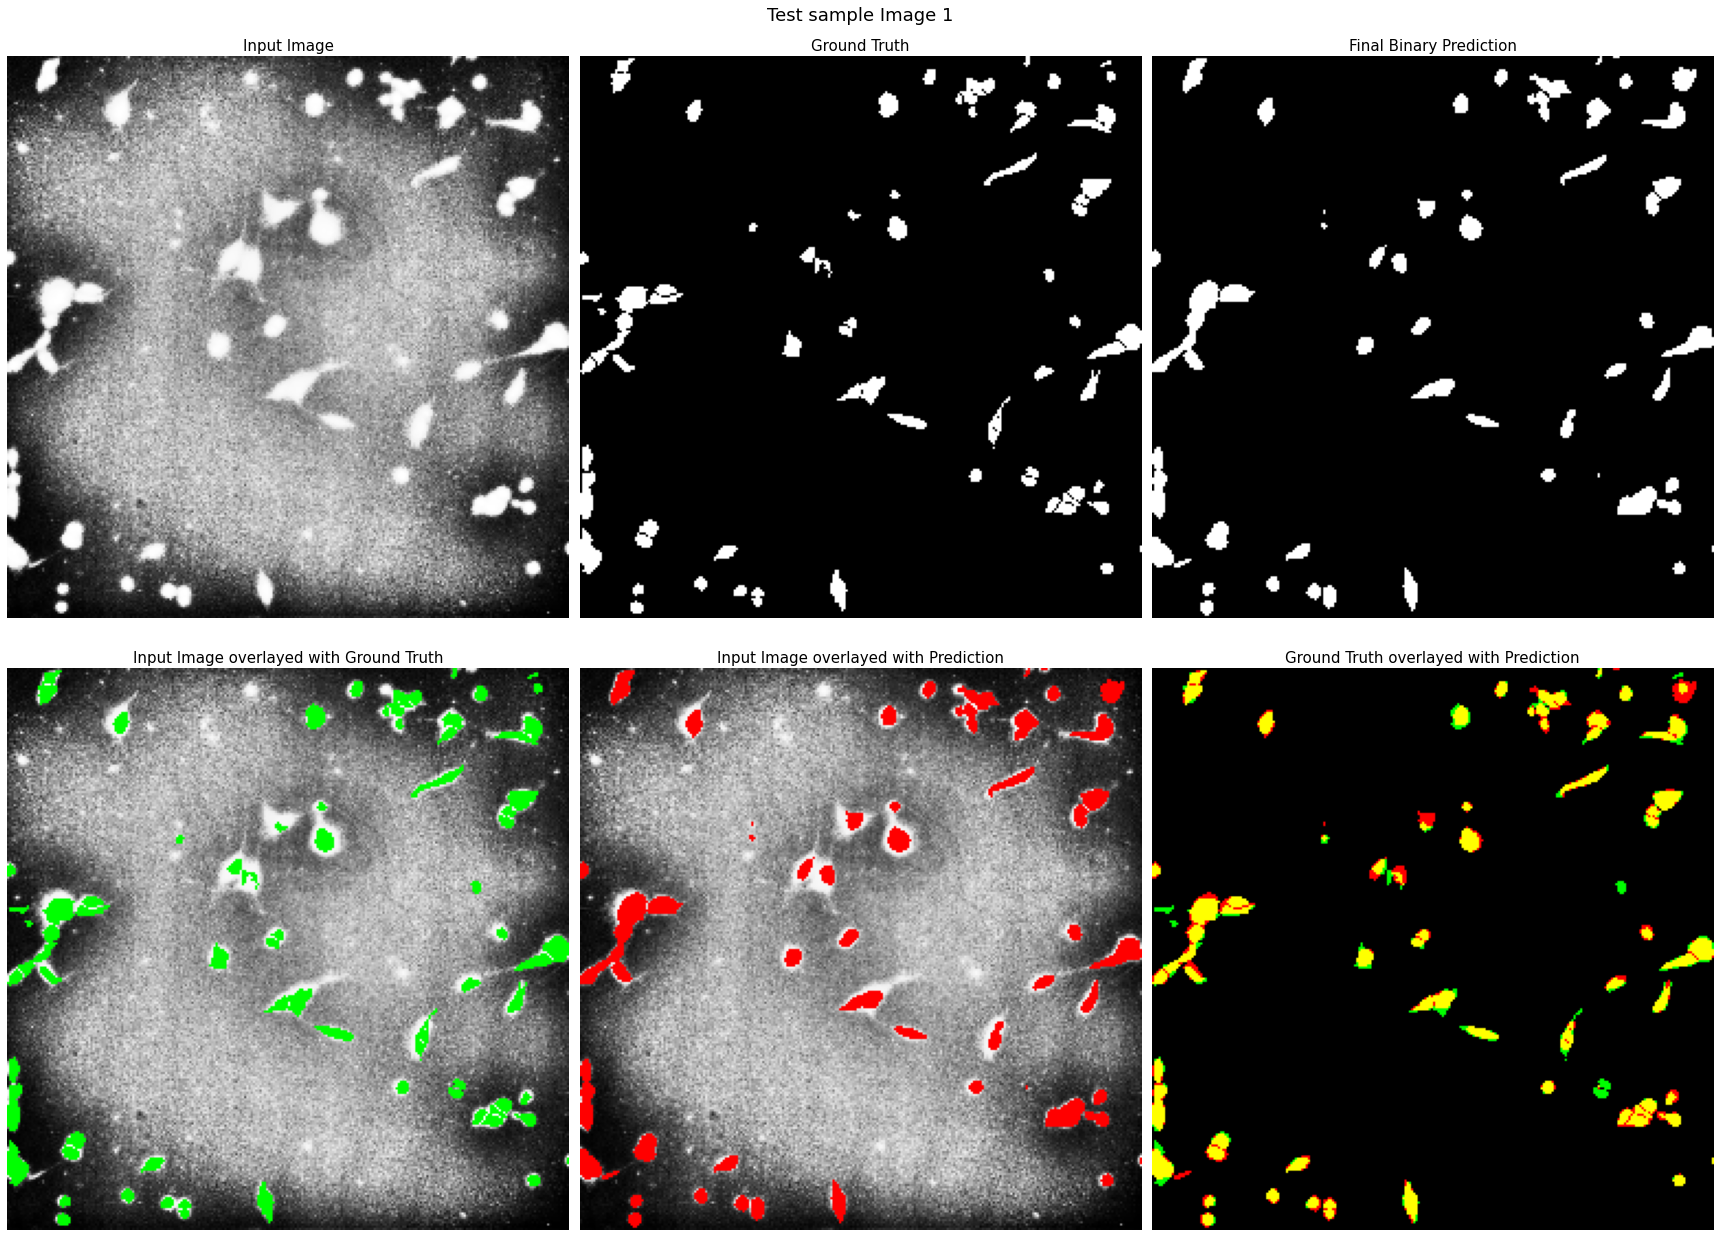

In [35]:
# Take the first batch of test set
for batch in test_dataloader:
    sample_batch = batch
    break
    
# Generat network prediction
with torch.no_grad():
    y_pred = my_UNet2(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(sample_batch['image'].shape, 
                                                                                                                       sample_batch['mask'].shape,
                                                                                                                       y_pred.shape
                                                                                                                      ))

# Conver Pytorch tensor to numpy array then reverse the preprocessing steps
img = (sample_batch['image'][0][0].numpy() * 255).astype('uint8')
msk = (sample_batch['mask'][0].numpy() * 255).astype('uint8')

# Using `np.argmax()`, we may choose the maximum likelihood to assign a label for each pixel
pred_msk_binary = (np.argmax(y_pred.cpu().numpy()[0], axis=0) * 255).astype('uint8')
# pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,18))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(2,3,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')


plt.subplot(2,3,3)
plt.title('Final Binary Prediction', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

input_overlayed_GT = img.copy()
input_overlayed_GT = cv2.cvtColor(input_overlayed_GT, cv2.COLOR_GRAY2RGB)
input_overlayed_GT[msk == 255, :] = [0, 255, 0]
plt.subplot(2,3,4)
plt.title('Input Image overlayed with Ground Truth', fontsize=15)
plt.imshow(input_overlayed_GT)
plt.axis('off')

input_overlayed_Pred = img.copy()
input_overlayed_Pred = cv2.cvtColor(input_overlayed_Pred, cv2.COLOR_GRAY2RGB)
input_overlayed_Pred[pred_msk_binary == 255, :] = [255, 0, 0]
plt.subplot(2,3,5)
plt.title('Input Image overlayed with Prediction', fontsize=15)
plt.imshow(input_overlayed_Pred)
plt.axis('off')

GT_overlayed_prediction = np.zeros_like(img)
GT_overlayed_prediction = cv2.cvtColor(GT_overlayed_prediction, cv2.COLOR_GRAY2RGB)
GT_overlayed_prediction[msk == 255, 1] = 255
GT_overlayed_prediction[pred_msk_binary == 255, 0] = 255
plt.subplot(2,3,6)
plt.title('Ground Truth overlayed with Prediction', fontsize=15)
plt.imshow(GT_overlayed_prediction)
plt.axis('off')

plt.tight_layout()
plt.show()

In [36]:
test_loss, test_dice, test_jaccard, test_accuracy, test_CM = test_net(my_UNet2, test_dataloader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Jaccard score: {test_jaccard}, Test overall accuracy: {test_accuracy}')

Test Loss: 0.0561452667415142, Test DICE score: 0.804057776927948, Test Jaccard score: 0.6724161505699158, Test overall accuracy: 0.9757334899902343


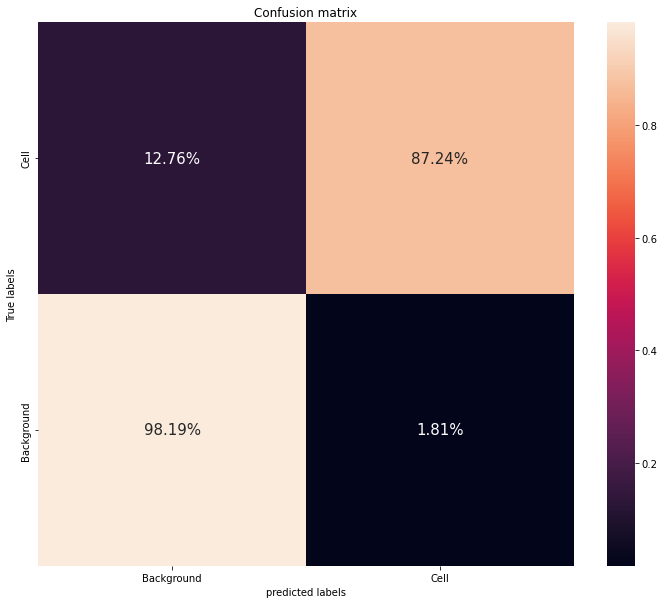

In [37]:
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2]);
plt.ylabel('True labels');
plt.xlabel('predicted labels');